In [120]:
import ffn # https://www.finlab.tw/ffn-intro/

import pandas_datareader.data as web
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
import scipy.signal

In [152]:
start = datetime(2019, 1, 1)
end = datetime(2019, 4, 1)

# TSM: 台積電
# 2317.TW: 鴻海
company = '2317.TW'
df = web.DataReader(company, 'yahoo', start) 

# 計算均線
df['7d'] = pd.Series.rolling(df['Close'], window=7).mean()
df['14d'] = pd.Series.rolling(df['Close'], window=14).mean()
df['30d'] = pd.Series.rolling(df['Close'], window=30).mean()
df['60d'] = pd.Series.rolling(df['Close'], window=60).mean()

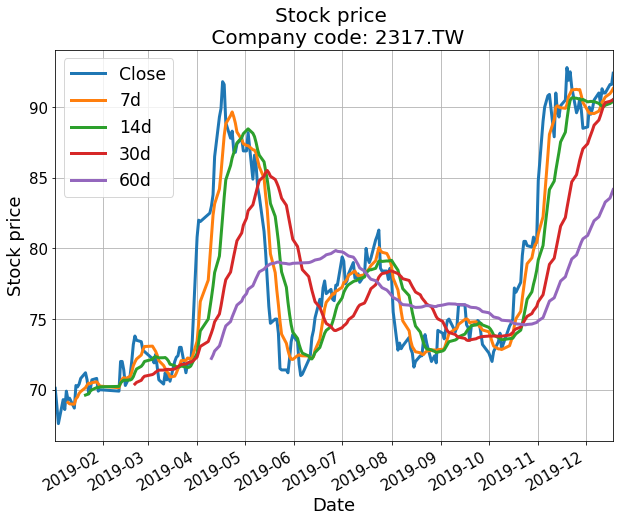

In [154]:
df[['Close','7d','14d','30d','60d']].plot(grid=True, figsize=(10,8),linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Stock price', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Stock price \n Company code: '+company,fontsize = 20)
plt.legend(loc='best',fontsize='xx-large')

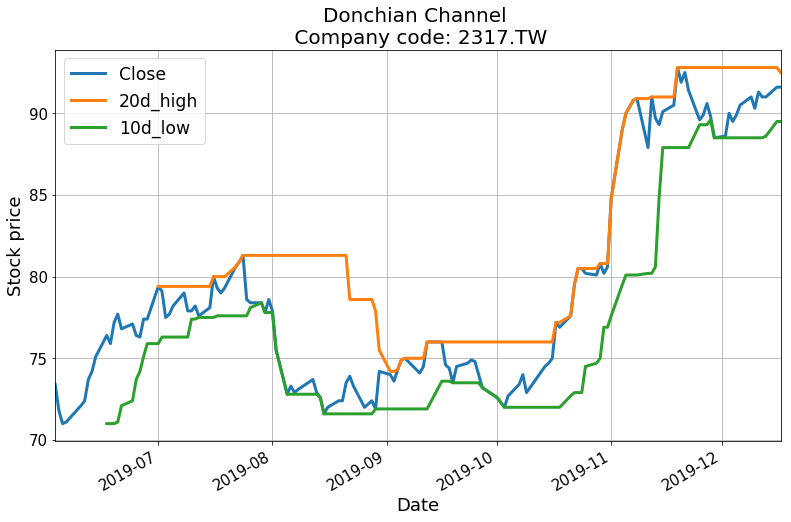

In [58]:
# Donchian Channel
df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()
df[['Close','20d_high','10d_low']].plot(grid=True, figsize=(13,8),linewidth=3)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Stock price', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Donchian Channel \n Company code: '+company,fontsize = 20)
plt.legend(loc='best',fontsize='xx-large')

In [103]:
def book_strategy(stra_str, df):
    if stra_str == 'breakout':
        # 進場點：突破前一日的 20 日高點
        # 出場點：突破前一日的 10 日低點

        # Donchian Channel
        df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
        df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

        has_position = False
        df['signals'] = 0
        for t in range(2, df['signals'].size):
            # print (t, has_position, df['Close'][t], df['20d_high'][t-1])
            if df['Close'][t] > df['20d_high'][t-1]:
                if not has_position:
                    # print ('Buy!!')
                    df.loc[df.index[t], 'signals'] = 1
                    has_position = True
            elif df['Close'][t] < df['10d_low'][t-1]:
                if has_position:
                    df.loc[df.index[t], 'signals'] = -1
                    has_position = False

        df['positions'] = df['signals'].cumsum().shift()

    # 底下這一行只是為了要在下面把 signals 跟 positions 畫出來做說明用
    # df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))
    elif stra_str == 'BBand':
        # 主要使用BBand + 5MA策略，
        # 中軌為20ma，上下軌為正負1.5sd
        # 若5MA開始向上突破下軌，低檔買進
        # 若收盤價向下跌破中軌，獲利了結趕快落跑

        df['5ma'] = pd.Series.rolling(df['Close'], window=5).mean()
        # bbands策略,N=20
        df['20ma'] = pd.Series.rolling(df['Close'], window=20).mean()
        df['SD'] = pd.Series.rolling(df['Close'], window=20).std()
        # 上軌=20ma+1.5sd ,中軌=20ma, 下軌=20ma-1.5sd
        df['upbbands'] = df['20ma']+1.5*df['SD']
        df['midbbands']=df['20ma']
        df['lowbbands'] = df['20ma']-1.5*df['SD']

        has_position = False
        df['signals'] = 0
        for t in range(2, df['signals'].size):
            if  (df['5ma'][t] > df['lowbbands'][t-1]):
                if not has_position:
                    df.loc[df.index[t], 'signals'] = 1
                    has_position = True
            elif  (df['Close'][t] < df['midbbands'][t-1]):
                if has_position:
                    df.loc[df.index[t], 'signals'] = -1
                    has_position = False

        df['positions'] = df['signals'].cumsum().shift()
        # return df  
    elif stra_str == 'WMSR':
        # WMSR < 80時進場
        # WMSR > 20時出場

        df['low9'] = df['Low'].rolling(window=9).min()
        df['high9'] = df['High'].rolling(window=9).max()
        df['WMSR'] = 100*((df['high9'] - df['Close']) / (df['high9'] - df['low9']) )

        has_position = False
        df['signals'] = 0
        for t in range(2, df['signals'].size):
            if df['WMSR'][t] < 80:
                if not has_position:
                    df.loc[df.index[t], 'signals'] = 1
                    has_position = True
            elif df['WMSR'][t] > 20:
                if has_position:
                    df.loc[df.index[t], 'signals'] = -1
                    has_position = False

        df['positions'] = df['signals'].cumsum().shift()
        # return df
    elif stra_str == 'BIAS':
        # 乖離率,乖離率代表的就是投資者的平均報酬率，當股價漲離平均成本很多的時候，
        # 就可能會有大的獲利賣壓出現，讓股價往均線跌回,當股價跌出平均成本太多的時候，攤平或逢低的買盤可能會進入
        # 乖離率<-3% 進場 , >3.5% 出場

        has_position = False
        df['6d'] = pd.Series.rolling(df['Close'], window=6).mean()
        df['BIAS'] = (df['Close'] - df['6d'] )/df['6d']
        df['signals'] = 0
        for t in range(2, df['signals'].size):
            if df['BIAS'][t] < -0.03:
                if not has_position:
                    df.loc[df.index[t], 'signals'] = 1
                    has_position = True
            elif df['BIAS'][t] > 0.03:
                if has_position:
                    df.loc[df.index[t], 'signals'] = -1
                    has_position = False

        df['positions'] = df['signals'].cumsum().shift()
        # return df
    elif stra_str == 'MACD':
         # MACD：對長期與短期的移動平均線 收斂或發散的徵兆，加以雙重平滑處理，
         #       用來判斷買賣股票的時機與訊號(確定波段漲幅 找到買賣點)
         # MACD策略：快線 (DIF) 向上突破 慢線 (MACD)。 → 買進訊號
         #          快線 (DIF) 向下跌破 慢線 (MACD)。→ 賣出訊號

        df['EMAfast'] = pd.Series.ewm(df['Close'], span = 12).mean()
        df['EMAslow'] = pd.Series.ewm(df['Close'], span = 26).mean()
        df['DIF'] = (df['EMAfast'] - df['EMAslow'])
        df['MACD'] = pd.Series.ewm(df['DIF'], span = 9).mean()

        has_position = False
        df['signals'] = 0
        for t in range(2, df['signals'].size):
            if df['DIF'][t-1]<df['MACD'][t] and df['DIF'][t]>df['MACD'][t]:
                if not has_position:
                    df.loc[df.index[t], 'signals'] = 1
                    has_position = True
            elif df['DIF'][t-1]>df['MACD'][t] and df['DIF'][t]<df['MACD'][t]:
                if has_position:
                    df.loc[df.index[t], 'signals'] = -1
                    has_position = False

        df['positions'] = df['signals'].cumsum().shift()
        # return df
    else:
        print ('Not an existing strategy!!!')


In [157]:
strategy_list = ['breakout','BBand','WMSR','BIAS','MACD']

df_list = []

for istra in range(len(strategy_list)):
    df_tmp=df.copy()
    book_strategy(strategy_list[istra], df_tmp)
    df_list.append(df_tmp)

# book_strategy('breakout', df)
# book_strategy('BBand', df)
# book_strategy('WMSR', df)
# book_strategy('BIAS', df)

# df_list[0].head()

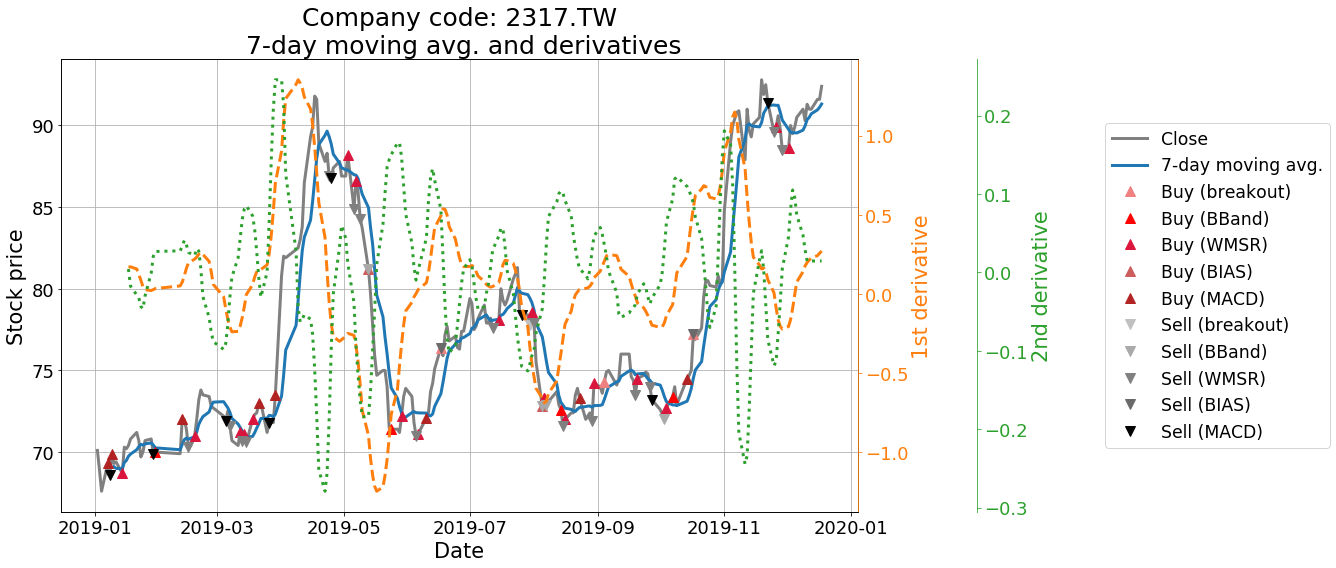

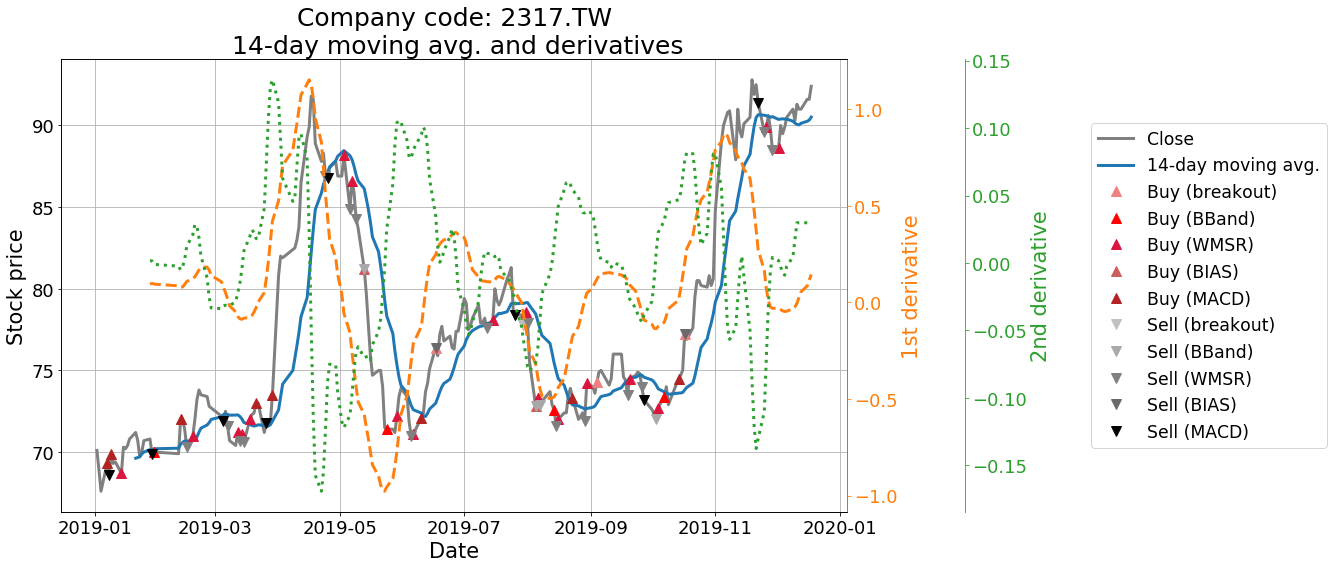

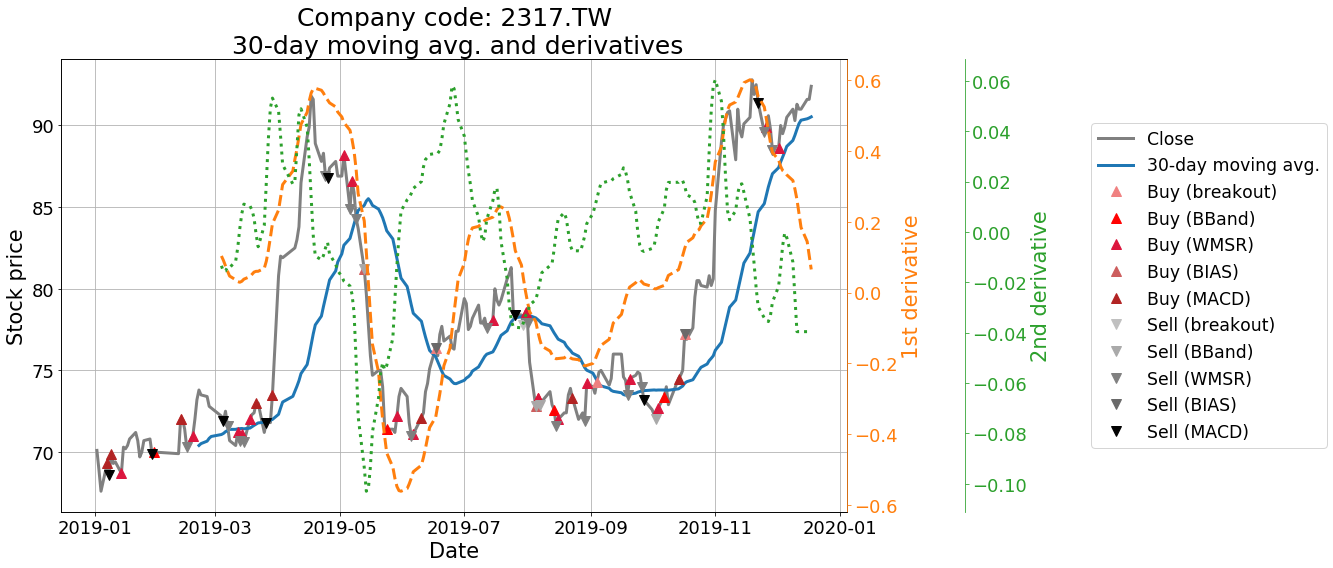

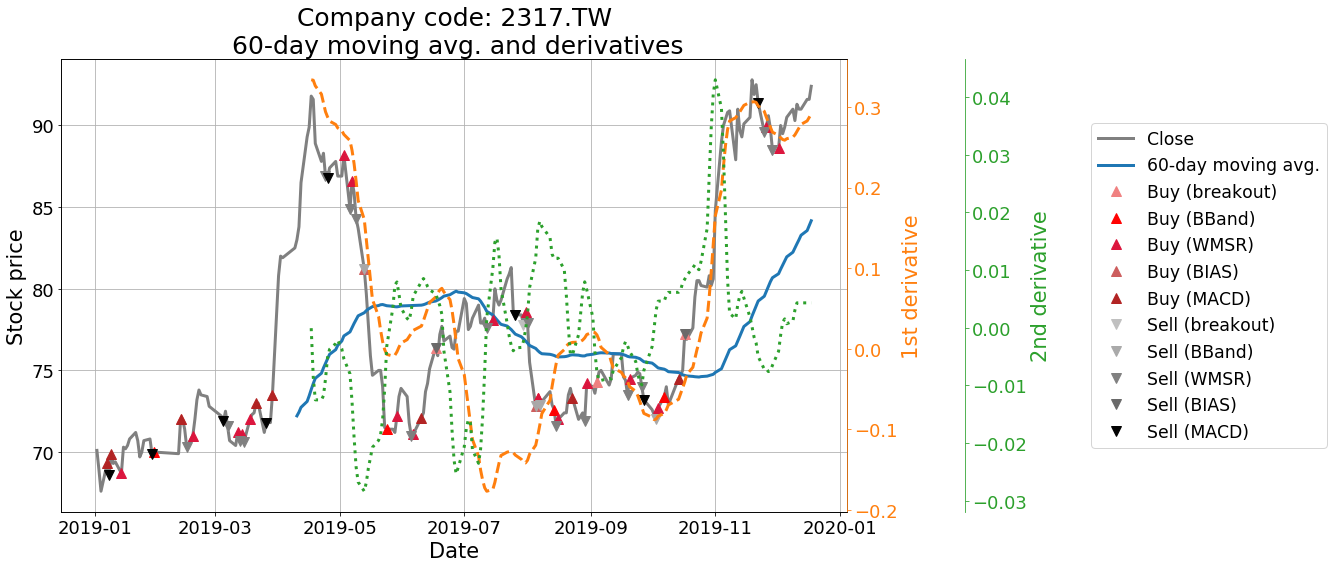

In [169]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

movavg_list = [7,14,30,60]
color_buy = ['lightcoral','red','crimson','indianred','firebrick']
color_sell = ['silver','darkgrey','grey','dimgray','black']

for imov in range(len(movavg_list)):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
    ax1.plot(df['Close'].index, df['Close'], color='gray', lw=3.)
    ax1.plot(df['%dd' %(movavg_list[imov])].index, df['%dd' %(movavg_list[imov])], lw=3.,label='%d-day moving avg.' %(movavg_list[imov]))
    ax1.set_xlabel('Date',fontsize=21)
    ax1.set_ylabel('Stock price', fontsize=21)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    
    plt.grid(True)

    ### Plot 1st derivatives of moving avg. lines
    ax2 = ax1.twinx()
    dev1st = scipy.signal.savgol_filter(df['%dd' %(movavg_list[imov])], window_length=11, polyorder=2, deriv=1)
    ax2.plot(df['%dd' %(movavg_list[imov])].index, dev1st, lw=3., color='C1',label='%d-day moving avg. 1st dev.' %(movavg_list[imov]), linestyle='--')
    ax2.tick_params(axis='y', labelsize=18, labelcolor='C1', colors='C1')
    ax2.set_ylabel('1st derivative', fontsize=21, color='C1')
    ax2.spines['right'].set_color('C1')

    ### Plot 2st derivatives of moving avg. lines
    ax3 = ax1.twinx()
    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    ax3.spines["right"].set_position(("axes", 1.15))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(ax3)
    # Second, show the right spine.
    ax3.spines["right"].set_visible(True)
    ax3.spines["right"].set_color('C2')

    dev2nd = scipy.signal.savgol_filter(df['%dd' %(movavg_list[imov])], window_length=11, polyorder=2, deriv=2)
    ax3.plot(df['%dd' %(movavg_list[imov])].index, dev2nd, lw=3., color='C2',label='%d-day moving avg. 2st dev.' %(movavg_list[imov]), linestyle='dotted')
    ax3.tick_params(axis='y', labelsize=18, labelcolor='C2', colors='C2')
    ax3.set_ylabel('2nd derivative', fontsize=21, color='C2')
    

    # Plot the "buy" trades
    for istra in range(len(strategy_list)):
        ax1.plot(df_list[istra].loc[df_list[istra].signals == 1].index,df_list[istra]['Close'][df_list[istra].signals == 1.0],
                 '^', markersize=10, color=color_buy[istra], alpha=.99, 
                 label='Buy ('+strategy_list[istra]+')')

    # Plot the "sell" trades
    for istra in range(len(strategy_list)):
        ax1.plot(df_list[istra].loc[df_list[istra].signals == -1].index,df_list[istra]['Close'][df_list[istra].signals == -1.0],
                 'v', markersize=10, color=color_sell[istra], alpha=.99, 
                 label='Sell ('+strategy_list[istra]+')')


    h1, l1 = ax1.get_legend_handles_labels()
    # h2, l2 = ax2.get_legend_handles_labels()
    # h3, l3 = ax3.get_legend_handles_labels()
    # ax1.legend(h1+h2+h3, l1+l2+l3, loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='xx-large')
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='xx-large')

    plt.title('Company code: '+company+'\n %d-day moving avg. and derivatives' %(movavg_list[imov]),fontsize = 25)

    plt.tight_layout()
    plt.savefig('./plots/Entries-and-exits-'+company+'-%d-day.png' %(movavg_list[imov]), bbox_inches = 'tight', dpi=500)
    plt.savefig('./plots/Entries-and-exits-'+company+'-%d-day.pdf' %(movavg_list[imov]), bbox_inches = 'tight')
